# <a href="https://miptstats.github.io/courses/ad_mipt.html">Phystech@DataScience</a>
## Домашнее задание 11

**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_pds_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно ноутбук в формате `ipynb`.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* **Код из рассказанных на занятиях ноутбуков можно использовать без ограничений.**

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Импорты из sklearn:

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor

## Задача 1

In [49]:
def plot_results(y_to_train, y_to_test, y_forecast, title): 
    """
    Функция для визуализации временного ряда и предсказания.
    Параметры:
        - y_to_train: pd.Series размер T_train
            Временной ряд, на котором обучалась модель.
        - y_to_test: pd.Series размер T_test
            Временной ряд, который предсказывает модель.
        - y_forecast: array размер T_test
            Предсказания модели.
        - title: str
            Название графика
    """
    
    plt.figure(figsize=(15, 5))
    plt.title(title, fontsize=15) 
    plt.plot(y_to_train, label="train")
    plt.plot(y_to_test, label="test")
    plt.plot(y_to_test.index, y_forecast, label="prediction") 
    plt.legend()
    plt.show()

def calc_metrics(y_true, y_pred):
    """
    Функция для подсчета метрик качества прогноза
    Параметры:
        - y_true: np.array, pd.Series,  размер T_test
            Вектор истинных значений таргета
        - y_pred: np.array, pd.Series, размер T_test
            Векотр предсказанных знаяений таргета
    """

    print('MSE: ', mean_squared_error(y_true, y_pred))
    print('MAE: ', mean_absolute_error(y_true, y_pred))
    print('MAPE: ', mean_absolute_percentage_error(y_true, y_pred))


def create_date_features(date):
    """Создает фичи из даты"""
    
    row = {}
    row['dayofweek'] = date.dayofweek
    row['quarter'] = date.quarter
    row['month'] = date.month
    row['year'] = date.year
    row['dayofyear'] = date.dayofyear
    row['dayofmonth'] = date.day
    row['weekofyear'] = date.weekofyear
    return row


def create_only_date_train_features(y_series):
    """
        Создает обучающий датасет из признаков, полученных из дат для y_series
    """
    
    time_features = pd.DataFrame([create_date_features(date) for date in y_series.index])
    return time_features, y_series


def create_shifted_features(
    y_series, shifts=5, week_seasonal_shifts=1, year_seasonal_shifts=1
):
    """
    Создает обучающий датасет из признаков, полученных из дат и значений ряда ранее.
    При этом используются значения ряда со сдвигами на неделю и год назад.
    Параметры:
        - y_series: pd.Series, размер T
            временной ряд.
        - shifts: int
            дневной сдвиг (сколько дней учитываем).
        - week_seasonal_shifts: int
            недельный сдвиг (сколько недель учитываем).
        - year_seasonal_shifts: int
            годовой сдвиг (сколько лет учитываем).
    """
    
    curr_df, y = create_only_date_train_features(y_series)
    curr_df.index = y_series.index

    # применяем сдвиг по дням
    for shift in range(1, shifts + 1):
        curr_df[f'shift_{shift}'] = y_series.shift(shift, axis=0)

    # применяем сдвиг по неделям
    for shift in range(1, week_seasonal_shifts + 1):
        curr_df[f"week_seasonal_shift_{shift}"] = y_series.shift(
            shift * 7, axis=0
        )
    
    # применяем сдвиг по годам
    for shift in range(1, year_seasonal_shifts + 1):
        curr_df[f"year_seasonal_shift_{shift}"] = y_series.shift(
            shift * 365, axis=0
        )

    y = y_series
    
    # удалим первые строчки с nan
    drop_indices = curr_df.index[curr_df.isna().sum(axis=1) > 0]
    curr_df = curr_df.drop(index=drop_indices)
    y = y.drop(index=drop_indices)
    return curr_df, y




def recursive_prediction(model, test_dates, y_to_train, features_creation_function):
    """
    Функция для рекурсивного предсказания для дат, указанных в test_dates.
    
    Параметры:
        - model
            Обученная МЛ-модель.
        - test_dates
            массив с датами, в которые надо сделать предсказания.
        - y_to_train
            Предыдущие значения
        - features_creation_function
            функция для создания тестовых признаков
    """

    predictions = []
    previous_y = list(y_to_train)
    
    for date in test_dates:

        # получаем признаки для тестовых данных из тестовой даты и предыдущих значений
        row = features_creation_function(date, previous_y)
        curr_test = pd.DataFrame([row])

        # выоплняем предсказание моделью
        curr_prediction = model.predict(curr_test)[0]

        # добавляем текущее предсказание к предыдущем значениям в список previous_y
        previous_y.append(curr_prediction)

        # сохраняем текущее предсказание для вердикта на тесте в список predictions
        predictions.append(curr_prediction)
    
    return np.array(predictions)

#### **Профиль биология**

### Загрузка данных
В этом задании вы будете работать с данными о распространении COVID-19, их можно скачать [здесь](https://www.kaggle.com/datasets/gpreda/coronavirus-2019ncov). Мы будем предказывать показатель смертности, потому что способы измерения выздоровевших и заболевших разнятся между регионами.

 В данных представлены следующие столбцы:

* `Country/Region` &mdash; страна или регион,

* `Province/State` &mdash; город или населенный пункт,
* `Latitude` &mdash; географическая широта,
* `Longitude` &mdash; географическая долгота,
* `Confirmed` &mdash; кол-во подтвержденных случаев заболевания,
* `Recovered` &mdash; кол-во подтвержденных случаев выздоровления,
* `Deaths` &mdash; кол-во смертей,
* `Date` &mdash; дата. 

Загрузим данные.

In [71]:
data = pd.read_csv('covid-19-all.csv').dropna()

<ipython-input-71-d8f9f193f70f>:1: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('covid-19-all.csv').dropna()


Колонку `Date` преобразуем к правильному типу данных и поставим вместо индексов.

In [72]:
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

Выберите любую страну из колонки `Country/Region` и любой крупный город из колонки `Province/State` (значения `Deaths` не должны опускаться ниже 2500). Обрежьте ваш датасет, чтобы в нем осталась информация только о выбранном городе.

In [73]:
country = 'Russia'
province = 'Moscow'

group = (data['Country/Region'] == country) & (data['Province/State'] == province) & (data['Deaths'] >= 2500)

data = data.loc[group]

Оставьте в ваших данных только столбец `Deaths`.

In [74]:
data = data['Deaths']

Визуализируйте, как изменяется таргет с течением времени. Какие зависимости вы можете увидеть?

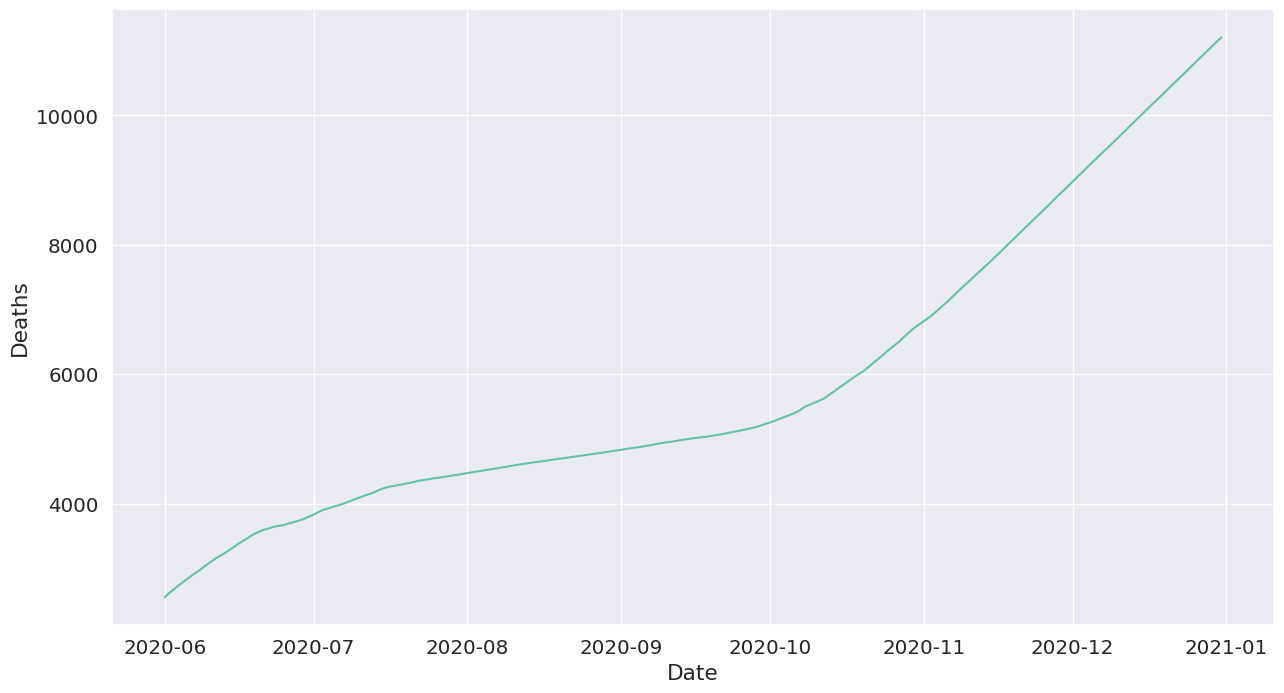

In [75]:
plt.figure(figsize=(15, 8))
plt.plot(data)
plt.xlabel('Date')
plt.ylabel('Deaths');

**Ответ:**Можем увидеть, что с каждым месяцем количество смертей увеличивается. Быстрый рост начинается с ноября 2021 года, происходит резкий скачок

Сгенерируйте новые временные признаки, основываясь на графиках выше. Допишите функцию для создания данных со сдвигом `create_shifted_features`. Помните, что у нас данные поступают каждый день, то есть сдвиг на 1 отвечает сдвигу на 1 день, сдвиг 7 отвечает сдвигу на 1 неделю, сдвиг на 365 отвечает сдвигу на год. 



In [85]:
X_data, Y_target = create_shifted_features(data, shifts=4, week_seasonal_shifts=2, year_seasonal_shifts=0)


Разбейте ваши данные таким образом, чтобы в тесте остался последние 20% измерений.

In [86]:
X_data.shape

(200, 13)

In [92]:
X_train,y_train = X_data[0:int(len(X_data)*0.8)], Y_target[0:int(len(Y_target)*0.8)]
X_test, y_test = X_data[int(len(X_data)*0.8):], Y_target[int(len(Y_target)*0.8):]


Обучите линейную регрессию с регуляризацией и случайный лес на ваших данных. Допишите функцию `recursive_prediction`. Посчитайте метрики с помощью функции `calc_metrics`.

In [93]:
def date_and_shift_features_generator_for_test(date, previous_y):
    """Функция создания признаков из дат исдвигов ряда для тестовых дат"""
    SHIFT = 4
    WEEK_SHIFT = 2
    YEAR_SHIFT = 0
    
    row = create_date_features(date)
    for shift in range(1, SHIFT + 1):
        row[f"shift_{shift}"] = previous_y[-1 * shift]
    for shift in range(1, WEEK_SHIFT + 1):
        row[f"week_seasonal_shift_{shift}"] = previous_y[-1 * shift * 7]
    for shift in range(1, YEAR_SHIFT + 1):
        row[f"year_seasonal_shift_{shift}"] = previous_y[-1 * shift * 365]
    return row

In [94]:
lin_regression = ElasticNet()
lin_regression.fit(X_train, y_train)
y_pred_lin_regression = recursive_prediction(lin_regression, y_test.index, y_train,
                              date_and_shift_features_generator_for_test)

In [95]:
calc_metrics(y_test, y_pred_lin_regression)

MSE:  1323.609511503656
MAE:  20.03517864512487
MAPE:  0.0018757374989247621


In [101]:
forest = RandomForestRegressor()
forest.fit(X_train, y_train)
y_forest_pred = recursive_prediction(forest, X_test.index, y_train,date_and_shift_features_generator_for_test)

In [102]:
calc_metrics(y_test, y_forest_pred)

MSE:  3389725.6819325
MAE:  1635.67425
MAPE:  0.16117559151971705


Визуализируйте полученные прогнозы с помощью функции `plot_results`.

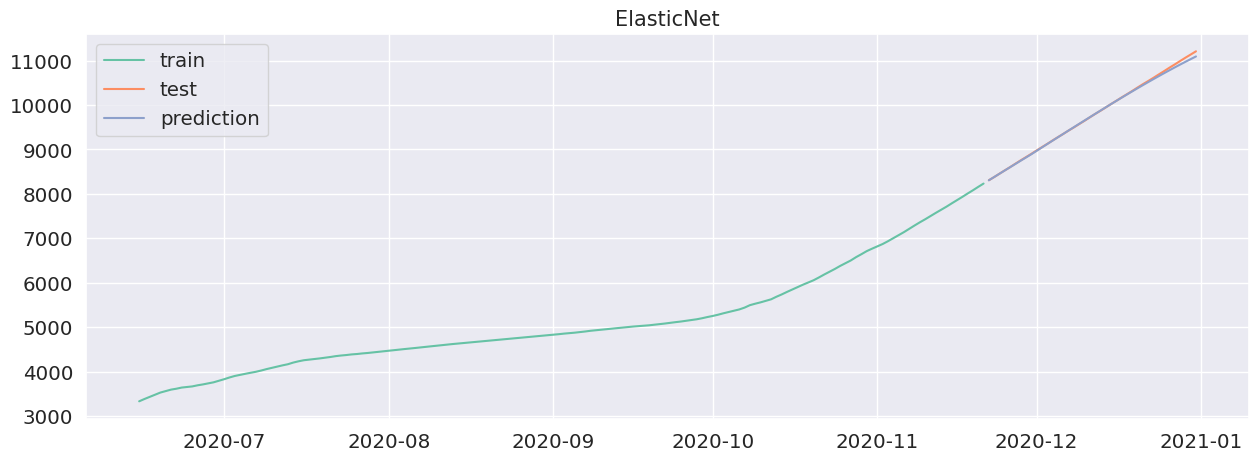

In [105]:
plot_results(y_train, y_test, y_pred_lin_regression, 'ElasticNet')

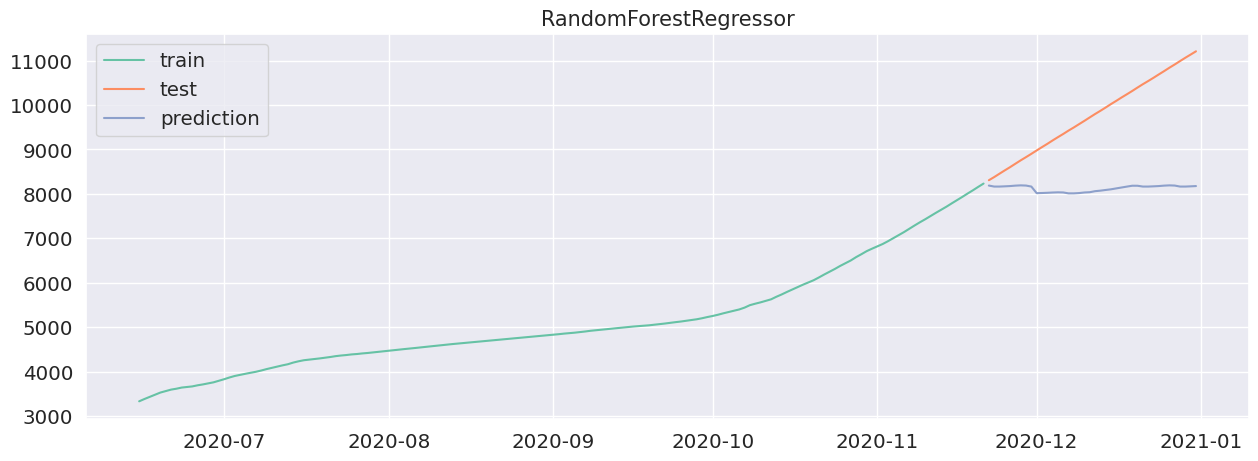

In [107]:
plot_results(y_train, y_test, y_forest_pred, "RandomForestRegressor")

Сделайте выводы.

** КурсивВывод:** Первая модель( лин р-я) предсказывает правдивее, чем рандомный лес. Линейная предсказывает очень похоже на тест